In [59]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [74]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

# Enter coordinates 
# coords = (29, -90, "NOLA")   #NOLA
# coords = (33.9, -118.6, "LA") # Los Angeles
coords = (40.6, -74, "NYC") # NYC coordinates

def generate_sea_level(area_coords):
    # Grab the approximate chunk for provided coords
    area_approx = rechunked.sea_level.sel(xt_ocean=area_coords[1], yt_ocean=area_coords[0], method="nearest")

    # Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
    coords_dict = {'time': sea_level_picontrol['time']}
    area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)
    
    return area_sea_level

sea_level = generate_sea_level(coords)

# Turn Data to tensors
time_int = cf_units.date2num(sea_level.time,'days since 0185-01-01 12:00:00' , calendar='julian')

In [75]:
def set_x_and_y(indexes, time, sea_level):
    """
    Input: array of indexes
    Output: Tensors for x and y (either train or test)
    """
    x = []
    y = [] 

    for i in indexes:
        x.append(time[i])
        y.append(sea_level[i])
        
    x = (np.array(x)).astype(float)
    y = (np.array(y)).astype(float)
        
    x = torch.FloatTensor(x).squeeze()
    y = torch.FloatTensor(y).squeeze()
    
    return x, y
        
def set_training_gap(data_size, gap_size, time, sea_level):
    """
    Input: sea_level data
    Output: Tensors with x_train y_train, x_test, and y_test
    """
    
    # Randomly choose points for training, the rest for testing
    indexes = list(range(0, data_size))
    training_indexes = np.arange(0, data_size-gap_size).reshape(-1, 1)
    testing_indexes = np.setdiff1d(indexes, training_indexes).reshape(-1, 1)
    
    x_train, y_train = set_x_and_y(training_indexes, time, sea_level)
    x_test, y_test = set_x_and_y(testing_indexes, time, sea_level)
    
    return x_train, y_train, x_test, y_test

In [76]:
# Change how many points we're using, how many gaps in the data, and the size of the gaps
data_size = 1000
gap_size = 200

#Input: size of data, size of gap, time data, sea level data
x_train, y_train, x_test, y_test = set_training_gap(data_size, gap_size, time_int, sea_level)

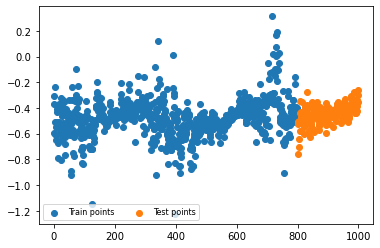

In [77]:
# Graph Our training and testing points for NOLA
train_plt = plt.scatter(x_train, y_train)
test_plt = plt.scatter(x_test, y_test)
plt.legend((train_plt, test_plt),
           ('Train points', 'Test points'),
           loc='lower left',
           scatterpoints=1,
           ncol=3,
           fontsize=8)
plt.show()

In [78]:
ytrain_mean = y_train.mean()
ytrain_std = y_train.std()

# Normalize training data
y_train = (y_train - y_train.mean()) / y_train.std()

# Normalize testing data
y_test = (y_test - ytrain_mean) / ytrain_std

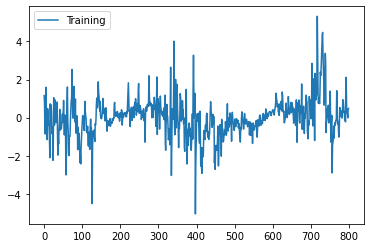

In [79]:
# Graph Our training points
train_plt = plt.plot(x_train, y_train, label="Training")
plt.legend(loc="upper left")
plt.show()

In [80]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=16)
        self.covar_module.initialize_from_data(x_train, y_train)
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [85]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 150

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

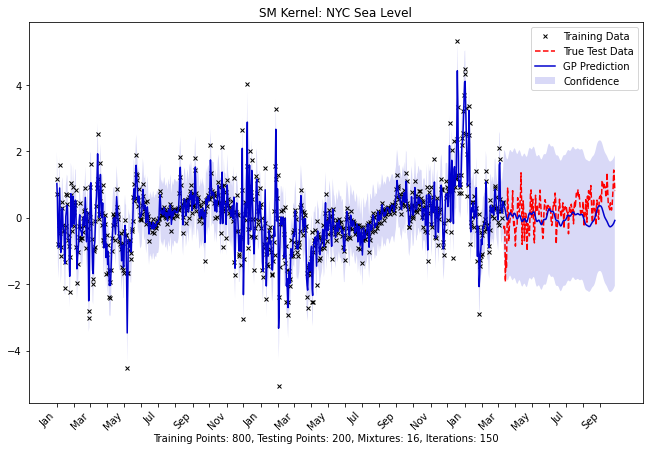

In [89]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():

    # Make predictions
    full_x = torch.cat((x_train, x_test))
    observed_pred_full = (likelihood(model(full_x)))

    dates_full = cf_units.num2date(full_x,'days since 0185-01-01 12:00:00' , calendar='julian')
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(11, 7))
        
    # Get upper and lower confidence bounds
    lower_full, upper_full = observed_pred_full.confidence_region()

    # Plot training data as black x's
    ax.plot(x_train, y_train.numpy(), 'x', color='black', markersize=4)
    
    # Plot test data as red line
    ax.plot(x_test, y_test.numpy(), '--', color='red', lw=1.5)

    # Plot predictive means as blue line
    ax.plot(full_x, observed_pred_full.mean.numpy(), 'mediumblue', lw=1.5)

    # Shade between the lower and upper confidence bounds
    ax.fill_between(full_x, lower_full.numpy(), upper_full.numpy(), facecolor='mediumblue',alpha=0.15)    
    
    #Add month axis labels
    month_starts = []
    month_names = [] 

    index = 0
    for date in dates_full:
        if date.day == 1:
            mnth = ""
            if (date.month == 1):
                mnth = 'Jan'
            if (date.month == 3):
                mnth = 'Mar'
            if (date.month == 5):
                mnth = 'May'
            if (date.month == 7):
                mnth = 'Jul'
            if (date.month == 9):
                mnth = 'Sep'
            if (date.month == 11):
                mnth = 'Nov'
            month_starts.append(index)
            month_names.append(mnth)
        index+=1

    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_names)
    plt.xticks(rotation=45, ha='right')

    #Set title, ledgend, and caption
    ax.set_title("SM Kernel: " + coords[2] + " Sea Level")
    ax.legend(['Training Data', 'True Test Data', 'GP Prediction', 'Confidence'])
    caption="Training Points: " + str(data_size-gap_size) + ", Testing Points: " + str(gap_size) +", Mixtures: "+ str(model.covar_module.num_mixtures) +", Iterations: " + str(training_iter)
    f.text(.5, .05, caption, ha='center')
